# Quantum Fourier Transform

In [114]:
from qiskit import QuantumCircuit
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram, plot_bloch_vector, plot_bloch_multivector
from qiskit.primitives import BackendSampler
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt

## Background QFT info

### Introducting to Fourier Transforms

It is very common in many different problems in various fields to "transform" the problem into some other problem with a known solution. Fortunately, some of these transformations can be computed with much greater speed on a quantum computer than a classical one. The transform we will be focusing on is called the discrete Fourier transform (DFT). Classically, the DFT takes a vector of complex numbers $x_j = (x_0,\dots,x_{N-1})$ with finite length $N$ as input returing an output of the vector $y_k = (y_0,\dots,y_{N-1})$. The returned vector $y_k$ is also complex and is defined by

$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{jk}$$

where $\omega_N^{jk} = e^{2\pi i\frac{jk}{N}}$ which gives us

$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_je^{2\pi i\frac{jk}{N}}$$

#### Discrete Fourier Transform Example

To understand the usefulness of the DFT, we will look at a common use case of this transformation in digital signal processing. This method will enable us to find the spectrum of a signal with some finite duration. Assume that the function $x(t)$ shown in $\text{Fig. }1$ is a continuous time signal we wish to analyze.

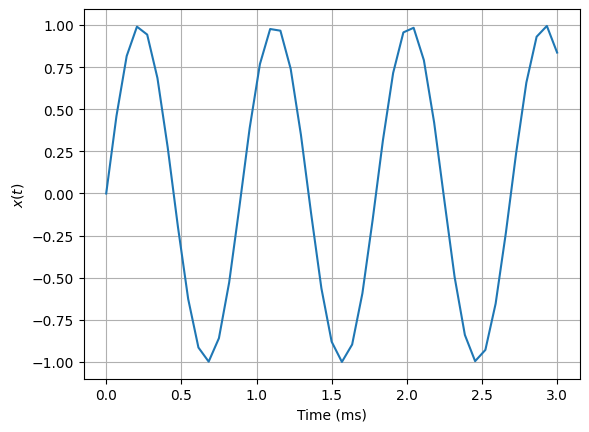

In [115]:
t = np.linspace(0,3,45)
sin = np.sin(7*t)
plt.plot(t,sin)
plt.grid()
plt.xlabel("Time (ms)")
plt.ylabel("$x(t)$")
plt.show()

$$\textbf{Fig. }1:\text{ Continuous time signal $x(t)$ which we wish to determine the frequency content}$$

Because $x(t)$ is a continuous signal, we are only able to analyze it on a digital computer if we discretize it into some number of samples of $x(t)$ and analyze these instead. The plot in $\text{Fig. }1$ also shows only the first $3.0\text{ ms}$ of our signal $x(t)$, which for all we know may continue far past this time for hours, years or even infinitely. A computer can obviously only process a finite number of samples, so to analyze this signal we must make an approximation and use a limited number of samples. To do this we will choose some finite duration sequence to represent the continuous time signal. Let's assume the $x(t)$ in $\text{Fig. }1$ was sampled at a rate of $15000\dfrac{\text{samples}}{\text{second}}$ and we take only $14$ samples leaving us with the plot of $x(n)$ in $\text{Fig. }2$.

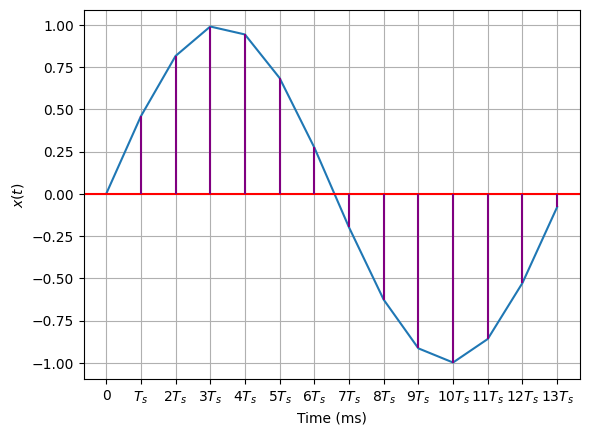

In [116]:
tn = t[:14]
plt.plot(tn,sin[:14])
plt.axhline(y=0, color='r')
plt.vlines(x = tn, ymin = 0, ymax = sin[:14], color = 'purple')
plt.xticks(tn,np.array(['0','$T_s$','$2T_s$','$3T_s$','$4T_s$','$5T_s$','$6T_s$','$7T_s$','$8T_s$','$9T_s$','$10T_s$','$11T_s$','$12T_s$','$13T_s$']))
plt.grid()
plt.xlabel("Time (ms)")
plt.ylabel("$x(t)$")
plt.show()

$$\textbf{Fig. }2:\text{ Sampling of continuous time signal $x(t)$}$$

Next, by normalizing our time axis to the sampling period $T_s=\frac{1}{f_s}$, we obtain a discrete sequence $x(n)$ representing our continuous time signal $x(t)$.

||||||||||||||||
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|$n$|0|1|2|3|4|5|6|7|8|9|10|11|12|13|
|$x(n)$|0.0|0.4594|0.8161|0.9904|0.9433|0.6855|0.2744|-0.1980|-0.6261|-0.9143|-0.9982|-0.8589|-0.5277|-0.0786|

In Fourier analysis, we have two options for analyzing discrete time signals: the discrete Fourier transform (DFT) and the discrete-time Fourier transform (DTFT). The DTFT for some input sequence $x(n)$ is given by

$$X(e^{i\omega}) = \sum_{n=-\infty}^{\infty}x(n)e^{-in\omega}$$

with its inverse as

$$x(n) = \frac{1}{2\pi} \int_{-\pi}^{\pi}X(e^{i\omega})e^{in\omega}d\omega$$

Using this equation, we are able to obtain the spectrum of some finite-duration signal $x(n)$. Unfortunately though, $X(e^{i\omega})$ is a continuous function of $\omega$ thus making it impossible for us to implement this equation exactly into a digital computer. But like we discussed before, we can use some number $L$ of evenly spaced samples of $X(e^{i \omega})$ to find some approximation of our spectrum $x(n)$. This method happens to be exactly the basis of how DFT works. 

Let's attempt to perform the DFT on our example of $x(t)$ in $\text{Fig. }1$ and $\text{Fig. }2$. Our goal is to obtain a set of exponentials and thus sinusoids which can be combined to produce our sampled signal $x(n)$. As was mentioned above, the DFT is based on a sampling of the DTFT with each sample at equally spaced frequency points. Because $X(e^{i\omega})$ is a periodic function in $\omega$ with a period of $2 \pi$, by taking $N$ total samples in each period of this function, the spacing between each of our frequency points will be $\frac{2\pi}{N}$. Therefore, the set of sinusoids that make up our function $x(n)$ will be of the form $\frac{2\pi}{N}\times k$ where $k = 0,1,\dots,N-1$. Using a similar complex exponential as above, the basis functions for the DFT will be $e^{2\pi i\frac{kn}{N}}$. Since we are seeking to obtain a weighted sum of these functions to give us $x(n)$, we can say 

$$x(n)=\sum_{k=0}^{N-1}X'(k)e^{2\pi i\frac{kn}{N}}$$

where $n=0,1,\dots,L-1$ and $X'(k)$ represents the weight used for the complex exponential. This equation represents the inverse discrete Fourier transform (IDFT). Expanding out the sum we can see that this equation is equivalent to the following set of equations:

$$x(0)=X'(0)e^{2\pi i\frac{0\cdot 0}{N}}+X'(1)e^{2\pi i\frac{1\cdot 0}{N}}+ \dots +X'(N-1)e^{2\pi i\frac{(N-1)\cdot 0}{N}} = X'(0)+X'(1)+ \dots +X'(N-1)$$

$$x(1)=X'(0)e^{2\pi i\frac{0\cdot 1}{N}}+X'(1)e^{2\pi i\frac{1\cdot 1}{N}}+ \dots +X'(N-1)e^{2\pi i\frac{(N-1)\cdot 1}{N}} = X'(0)+X'(1)e^{\frac{2\pi i}{N}}+ \dots +X'(N-1)e^{2\pi i\frac{(N-1)}{N}}$$

$$x(2)=X'(0)e^{2\pi i\frac{0\cdot 2}{N}}+X'(1)e^{2\pi i\frac{1\cdot 2}{N}}+ \dots +X'(N-1)e^{2\pi i\frac{(N-1)\cdot 2}{N}} = X'(0)+X'(1)e^{\frac{4\pi i}{N}}+ \dots +X'(N-1)e^{4\pi i\frac{(N-1)}{N}}$$

$$\vdots$$

$$x(L-1) = X'(0)e^{2\pi i\frac{0\cdot (L-1)}{N}}+X'(1)e^{2\pi i\frac{1\cdot (L-1)}{N}}+ \dots +X'(N-1)e^{2\pi i\frac{(N-1)\cdot (L-1)}{N}} = X'(0)+X'(1)e^{2\pi i\frac{(L-1)}{N}}+ \dots +X'(N-1)e^{2\pi i\frac{(N-1)(L-1)}{N}}$$

From this we know for given values of $N$ and $L$ we can compute the complex exponentials. It then follows that if we know the value of the signal in the time domain, we can compute the coefficients $X'(k)$. The number of samples in our time domain, $L$, tells us the number of equations in the set of equations above. The number of samples in our frequency domain $X(e^{i\omega})$ gives us the number of unknowns in our set of equations. When $N=L$, we have $N$ linearly independent equations in order to find $N$ unknowns $X'(k)$.

Another way to interpret this formula is as a matrix and vector. By simply using the coefficients of each equation, we can construct the following matrix-vector multiplication:

$$\begin{pmatrix}x(0)\\ x(1)\\ x(2)\\ \vdots \\ x(L-1) \end{pmatrix} = \begin{pmatrix}1 & 1 & 1 & \dots & 1 \\ 1 & \omega & \omega ^2 & \dots & \omega ^{N-1} \\ 1 & \omega ^2 & \omega ^4 & \dots & \omega^{2(N-1)} \\ \vdots & \vdots & \vdots & \ddots & \vdots \\ 1 & \omega ^{N-1} & \omega ^{2(N-1)} & \dots & \omega ^{(N-1)^2} \end{pmatrix} \begin{pmatrix}X'(0)\\ X'(1)\\ X'(2)\\ \vdots \\ X'(N-1) \end{pmatrix}$$

where $\omega = e^{2\pi i\frac{kn}{N}}$. This notation helps us clearly see how the DFT is effectively a matrix transforming a vector of amplitudes. So for us to find the vector $X'(k)$, letting $L=N=14$, we can multiply the vector $x(n)$ by the DFT matrix.

$$X'(k)=\frac{1}{N}\sum_{n=0}^{N-1}x(n)e^{-2\pi i\frac{kn}{N}}$$

We will accomplish this for our example using numpy in python.

In [117]:
def dft_matrix(N):
    n = np.arange(N)
    k = n[:, None]
    W = np.exp(-2j * np.pi * k * n / N)
    return W

def dft(x):
    N = len(x)
    W = dft_matrix(N)
    X = np.dot(W, x)
    return X

x = sin[:14]

X = np.round(dft(x)/(N),decimals=4)
print("DFT coefficients X'(k):",X)


NameError: name 'N' is not defined

|$k$|$X'(k)$|
|---|---|
|$0$|$-0.0041$|
|$1$|$0.1527-0.8277i$|
|$2$|$-0.0328+0.0716i$|
|$3$|$-0.0276+0.0355i$|
|$4$|$-0.0263+0.0213i$|
|$5$|$-0.0257+0.0125i$|
|$6$|$-0.0255+0.0059i$|
|$7$|$-0.0255$|
|$8$|$-0.0255-0.0059i$|
|$9$|$-0.0257-0.0125i$|
|$10$|$-0.0263-0.0213i$|
|$11$|$-0.0276-0.0355i$|
|$12$|$-0.0328-0.0716i$|
|$13$|$0.1527+0.8277i$|


Now subbing our exponential values into the set of equations above, we get

$$x(n) = X'(0)e^{2\pi i\frac{0\cdot n}{N}}+X'(1)e^{2\pi i\frac{1\cdot n}{N}}+ X'(2)e^{2\pi i\frac{2\cdot n}{N}} + X'(3)e^{2\pi i\frac{3\cdot n}{N}}+ X'(4)e^{2\pi i\frac{4\cdot n}{N}}+ X'(5)e^{2\pi i\frac{5\cdot n}{N}}+ X'(6)e^{2\pi i\frac{6\cdot n}{N}}+$$
$$+X'(7)e^{2\pi i\frac{7\cdot n}{N}}+ X'(8)e^{2\pi i\frac{8\cdot n}{N}}+ X'(9)e^{2\pi i\frac{9\cdot n}{N}}+ X'(10)e^{2\pi i\frac{10\cdot n}{N}}+ X'(11)e^{2\pi i\frac{11\cdot n}{N}}+ X'(12)e^{2\pi i\frac{12\cdot n}{N}}+ X'(13)e^{2\pi i\frac{13\cdot n}{N}}$$

Finally, putting in our values of $X'(k)$, we obtain
$$x(n)= (-0.0041)e^{2\pi i\frac{n}{14}}+(0.1527-0.8277i)e^{2\pi i\frac{n}{14}}+ (-0.0328+0.0716i)e^{2\pi i\frac{2n}{14}} + (-0.0276+0.0355i)e^{2\pi i\frac{3n}{14}}+ $$
$$+(0.0263+0.0213i)e^{2\pi i\frac{4n}{14}}+ (-0.0257+0.0125i)e^{2\pi i\frac{5n}{14}}+ (-0.0255+0.0059i)e^{2\pi i\frac{6n}{14}}+$$
$$+(-0.0255)e^{2\pi i\frac{7n}{N}}+ (-0.0255-0.0059i)e^{2\pi i\frac{8n}{N}}+ (-0.0257-0.0125i)e^{2\pi i\frac{9n}{N}}+ (-0.0263-0.0213i)e^{2\pi i\frac{10n}{N}}+$$
$$+(-0.0276-0.0355i)e^{2\pi i\frac{11n}{N}}+ (-0.0328-0.0716i)e^{2\pi i\frac{12n}{N}}+ (0.1527+0.8277i)e^{2\pi i\frac{13n}{N}}$$

which can be easily simplified to a sum of sinusoids using Euler's formula.

### Quantum Fourier Transform

As it turns out, this $N\times N$ matrix is unitary, thus making it a valid quantum operation. This is the quantum Fourier transform $(\text{QFT})$ which is functionally the exact same transformation as the DFT, though with a bit different notation. The $\text{QFT}$ acts on an orthonormal basis of a quantum state $|\Psi\rangle = \sum_{j=0}^{N-1}x_j|j\rangle = x_0|0\rangle,\dots,x_{N-1}|N-1\rangle$ outputing a different quantum state $|\Phi\rangle = \sum_{k=0}^{N-1}y_k|k\rangle = y_0|0\rangle,\dots,y_{N-1}|N-1\rangle$ defined by the formula

$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{jk} = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_je^{2\pi i\frac{jk}{N}}$$

This is more commonly expressed as the map

$$|j\rangle \mapsto \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}e^{2\pi i\frac{jk}{N}}|k\rangle$$

or the unitary matrix sum

$$U_{QFT} = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}\sum_{k=0}^{N-1}e^{2\pi i\frac{jk}{N}}|k\rangle \langle j|$$

For example, if we have a normalized quantum state

$$|\Psi\rangle = \begin{pmatrix}x_0 \\ x_1 \\ \vdots \\ x_{N-1}\end{pmatrix} = x_0|0\rangle+\dots+x_{N-1}|N-1\rangle$$

then applying the $\text{QFT}$ to this state will result in another normalized quantum state

$$|\Phi\rangle = \begin{pmatrix}y_0 \\ y_1 \\ \vdots \\ y_{N-1}\end{pmatrix} = y_0|0\rangle+\dots+y_{N-1}|N-1\rangle$$

where we call this the quantum Fourier transform of $|\Psi\rangle$. Therefore we can say $|\Psi\rangle$ maps to $|\Phi\rangle$ in the following way:

$$|\Psi\rangle = \sum_{j=0}^{N-1}x_j|j\rangle \mapsto |\Phi\rangle = \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}\sum_{j=0}^{N-1}x_je^{2\pi i\frac{jk}{N}}|k\rangle = \sum_{k=0}^{N-1}y_k|k\rangle$$

In simple terms, the QFT transforms between two bases: the computational basis ($Z$ basis), and the Fourier basis. Let's look at the QFT for various small values of $N$ to see what it means. By defining $\omega_N = e^{\frac{2\pi i}{N}} = \cos(\frac{2\pi}{N}) + i \sin(\frac{2\pi}{N})$ we can compute the QFT for any number of qubits:

$$\text{QFT}_N = \frac{1}{\sqrt{N}}\begin{pmatrix}1 & 1 & 1 & \dots & 1 \\ 1 & \omega & \omega ^2 & \dots & \omega ^{N-1} \\ 1 & \omega ^2 & \omega ^4 & \dots & \omega^{2(N-1)} \\ \vdots & \vdots & \vdots & \ddots & \vdots \\ 1 & \omega ^{N-1} & \omega ^{2(N-1)} & \dots & \omega ^{(N-1)^2} \end{pmatrix}$$

$$\text{QFT}_1 = \frac{1}{\sqrt{1}}\begin{pmatrix}1 \end{pmatrix} = \begin{pmatrix}1 \end{pmatrix}$$

$$\text{QFT}_2 = \frac{1}{\sqrt{2}}\begin{pmatrix}1 & 1 \\ 1 & \omega \end{pmatrix} = \frac{1}{\sqrt{2}}\begin{pmatrix}1 & 1 \\ 1 & e^{\frac{2\pi i}{N}} \end{pmatrix} = \frac{1}{\sqrt{2}}\begin{pmatrix}1 & 1 \\ 1 & \cos(\frac{2\pi}{2}) + i \sin(\frac{2\pi}{2}) \end{pmatrix} = \frac{1}{\sqrt{2}}\begin{pmatrix}1 & 1 \\ 1 & \cos(\pi) + i \sin(\pi) \end{pmatrix} = \frac{1}{\sqrt{2}}\begin{pmatrix}1 & 1 \\ 1 & -1 \end{pmatrix} = H$$

$$\text{QFT}_3 = \frac{1}{\sqrt{3}}\begin{pmatrix}1 & 1 & 1 \\ 1 & \omega & \omega ^2 \\ 1 & \omega ^2 & \omega ^4 \end{pmatrix} = \frac{1}{\sqrt{3}}\begin{pmatrix}1 & 1 & 1 \\ 1 &  e^{\frac{2\pi i}{N}} &  e^{\frac{4\pi i}{N}} \\ 1 &  e^{\frac{4\pi i}{N}} &  e^{\frac{8\pi i}{N}} \end{pmatrix} = \frac{1}{\sqrt{3}}\begin{pmatrix}1 & 1 & 1 \\ 1 &  \cos(\frac{2\pi}{3}) + i \sin(\frac{2\pi}{3}) &  \cos(\frac{4\pi}{3}) + i \sin(\frac{4\pi}{3}) \\ 1 & \cos(\frac{4\pi}{3}) + i \sin(\frac{4\pi}{3}) &  \cos(\frac{8\pi}{3}) + i \sin(\frac{8\pi}{3}) \end{pmatrix} = \frac{1}{\sqrt{3}}\begin{pmatrix}1 & 1 & 1 \\ 1 & \frac{-1 + i\sqrt{3}}{2} & \frac{-1 - i\sqrt{3}}{2} \\ 1 & \frac{-1 - i\sqrt{3}}{2} &  \frac{-1 + i\sqrt{3}}{2} \end{pmatrix}$$

$$\text{QFT}_8 = \frac{1}{\sqrt{8}}\begin{pmatrix}1 & 1 & 1 & 1 & 1 & 1 & 1 & 1\\ 1 & \omega & \omega ^2 & \omega ^3 & \omega ^4 & \omega ^5 & \omega ^6 & \omega ^7 \\ 1 & \omega ^2 & \omega ^4 & \omega ^6 & \omega ^8 & \omega ^{10} & \omega ^{12} & \omega ^{14} \\ 1 & \omega ^3 & \omega ^6 & \omega ^9 & \omega ^{12} & \omega ^{15} & \omega ^{18} & \omega ^{21} \\ 1 & \omega ^4 & \omega ^8 & \omega ^{12} & \omega ^{16} & \omega ^{20} & \omega ^{24} & \omega ^{28} \\ 1 & \omega ^5 & \omega ^{10} & \omega ^{15} & \omega ^{20} & \omega ^{25} & \omega ^{30} & \omega ^{35} \\ 1 & \omega ^6 & \omega ^{12} & \omega ^{18} & \omega ^{24} & \omega ^{30} & \omega ^{36} & \omega ^{42} \\ 1 & \omega ^7 & \omega ^{14} & \omega ^{21} & \omega ^{28} & \omega ^{35} & \omega ^{42} & \omega ^{49} \end{pmatrix} = \frac{1}{2\sqrt{2}}\begin{pmatrix}1 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\ 1 & e^{\frac{\pi i}{4}} & e^{\frac{\pi i}{2}} & e^{\frac{3\pi i}{4}} & e^{\pi i} & e^{\frac{4\pi i}{4}} & e^{\frac{3\pi i}{2}} & e^{\frac{7\pi i}{4}} \\ 1 & e^{\frac{\pi i}{2}} & e^{\pi i} & e^{\frac{3\pi i}{2}} & e^{2\pi i} & e^{\frac{5\pi i}{2}} & e^{3\pi i} & e^{\frac{7\pi i}{2}} \\ 1 & e^{\frac{3\pi i}{4}} & e^{\frac{3\pi i}{2}} & e^{\frac{9\pi i}{4}} & e^{3\pi i} & e^{\frac{15\pi i}{4}} & e^{\frac{9\pi i}{2}} & e^{\frac{21\pi i}{4}} \\ 1 & e^{\pi i} & e^{2\pi i} & e^{3\pi i} & e^{4\pi i} & e^{5\pi i} & e^{6\pi i} & e^{\frac{35\pi i}{4}} \\ 1 & e^{\frac{3\pi i}{2}} & e^{3\pi i} & e^{\frac{9\pi i}{2}} & e^{6\pi i} & e^{\frac{15\pi i}{2}} & e^{9\pi i} & e^{\frac{21\pi i}{2}} \\ 1 & e^{\frac{7\pi i}{4}}& e^{\frac{7\pi i}{2}} & e^{\frac{21\pi i}{4}} & e^{7\pi i} & e^{\frac{35\pi i}{4}} & e^{\frac{21\pi i}{2}} & e^{\frac{49\pi i}{4}} \end{pmatrix}$$

$$ = \frac{1}{2\sqrt{2}}\begin{pmatrix}1 & 1 & 1 & 1 & 1 & 1 & 1 & 1\\ 1 & \frac{1+i}{\sqrt{2}} & i & \frac{-1+i}{\sqrt{2}} & -1 & \frac{-1-i}{\sqrt{2}} & -i & \frac{1-i}{\sqrt{2}} \\ 1 & i & -1 & -i & 1 & i & -1 & -i \\ 1 & \frac{-1+i}{\sqrt{2}} & -i & \frac{1+i}{\sqrt{2}} & -1 & \frac{1-i}{\sqrt{2}} & i & \frac{-1-i}{\sqrt{2}} \\ 1 & -1 & 1 & -1 & 1 & -1 & 1 & -1 \\ 1 & \frac{-1-i}{\sqrt{2}} & i & \frac{1-i}{\sqrt{2}} & -1 & \frac{1+i}{\sqrt{2}} & -i & \frac{-1+i}{\sqrt{2}} \\ 1 & -i & -1 & i & 1 & -i & -1 & i \\ 1 & \frac{1-i}{\sqrt{2}} & -i & \frac{-1-i}{\sqrt{2}} & -1 & \frac{-1+i}{\sqrt{2}} & i & \frac{1+i}{\sqrt{2}} \end{pmatrix} $$

Looking at $\text{QFT}_2$ which is the transform for $n=1$ qubits because $N=2^n$, we see that this is exactly the Hadamard gate $H$. As we know, this gate transforms the $Z$-basis states $|0\rangle$ and $|1\rangle$ to the Fourier-basis states $|+\rangle$ and $|-\rangle$ respectively. Similarly, every multi-qubit state in the computational basis has a corresponding Fourier basis state like this. So like we mentioned before, the $\text{QFT}$ is just a transformation between these two bases. States in the Fourier basis are often denoted with a tilde (~). For example, the $\text{QFT}$ on the state $|x\rangle$ is notated as 

$$\text{QFT}|x\rangle = |\tilde{x}\rangle$$

What about $\text{QFT}_N$ for large values of N? In an $n$-qubit system where $N=2^n$, we can derive the $\text{QFT}$ acting on a state $|x\rangle = |x_1\dots x_n\rangle$ where $x_1$ is our most significant bit. Starting with our $\text{QFT}_N$ summation, we proceed with the following steps:

$$\text{QFT}_N|x\rangle = \frac{1}{\sqrt{N}}\sum_{y=0}^{N-1}e^{2\pi i\frac{xy}{2^n}}|y\rangle$$

We can rewrite this equation using fractional binary notation where $y = y_1y_2...y_n$ and $\frac{y}{2^n} = \sum_{k=1}^m\frac{y_k}{2^k}$ which gives

$$\text{QFT}_N|x\rangle = \frac{1}{\sqrt{N}}\sum_{y=0}^{N-1}e^{2\pi ix\left(\sum_{k=1}^n\frac{y_k}{2^k}\right)}|y_1\dots y_n\rangle$$

We can then expand the sum in our exponential to a product of exponentials leaving us with

$$\text{QFT}_N|x\rangle = \frac{1}{\sqrt{N}}\sum_{y=0}^{N-1}\prod_{k=1}^ne^{2\pi i\frac{xy_k}{2^k}}|y_1\dots y_n\rangle$$

By rearranging our sum and products and expanding $\sum_{y=0}^{N-1} = \sum_{y_1=0}^{1}\sum_{y_2=0}^{1}\dots\sum_{y_n=0}^{1}$ we are able to obtain

$$\frac{1}{\sqrt{N}}\sum_{y_1=0}^{1}\sum_{y_2=0}^{1}\dots\sum_{y_n=0}^{1}\bigotimes_{k=1}^{n}e^{2\pi i\frac{xy_k}{2^k}}|y_k\rangle = \frac{1}{\sqrt{N}}\bigotimes_{k=1}^{n}\left[\sum_{y_k=0}^{1}e^{2\pi i\frac{xy_k}{2^k}}|y_k\rangle \right] = \frac{1}{\sqrt{N}}\bigotimes_{k=1}^{n}\left[|0\rangle + e^{2\pi i\frac{x}{2^k}}|1\rangle \right]$$

which when expanded, finally leaves us with

$$\frac{1}{\sqrt{N}}\left(|0\rangle +e^{\frac{2\pi ix}{2}}|1\rangle \right)\otimes \left(|0\rangle +e^{\frac{2\pi ix}{2^2}}|1\rangle \right)\otimes \dots \otimes \left(|0\rangle +e^{\frac{2\pi ix}{2^{n-1}}}|1\rangle \right)\otimes \left(|0\rangle +e^{\frac{2\pi ix}{2^n}}|1\rangle \right)$$

and in binary

$$\frac{1}{\sqrt{N}}\left(|0\rangle +e^{2\pi i0.x_n}|1\rangle \right)\otimes \left(|0\rangle +e^{2\pi i0.x_{n-1}x_n}|1\rangle \right)\otimes \dots \otimes \left(|0\rangle +e^{2\pi i0.x_2x_3\dots x_{n}}|1\rangle \right)\otimes \left(|0\rangle +e^{2\pi i0.x_1x_2\dots x_n}|1\rangle \right)$$

In order to really understand what is happening between these two bases, we can look at how different states in each basis is represented on the Bloch sphere. The .gif's in $\text{Fig. }1$ and $\text{Fig. }2$ are taken from the Qiskit notebook on the QFT and show very clearly how a number in the computational and Fourier bases are represented with 4 qubits. In the computational basis, we can see that the leftmost qubit has the highest "flipping" frequency where it flips with every step up. The second qubit, qubit $1$, flips twice as frequently as qubit $0$, and the next twice as much as that and the pattern continues. So any subsequent qubit in the computational basis will have double the frequency as the qubit before it and so on. 

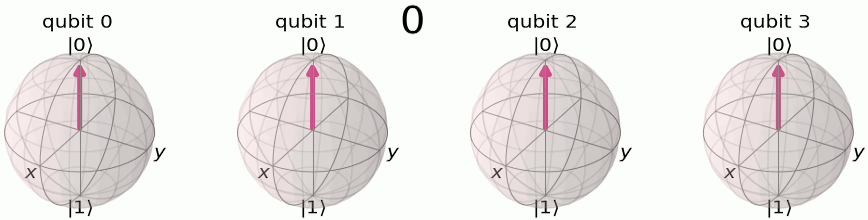

$$\textbf{Fig. }1:\text{ Counting in Computational Basis}$$

Looking at how we count in the Fourier basis in $\text{Fig. }2$, we can see that each number is instead represented as a rotation around the $Z$-axis. Starting with the $|\tilde{0}\rangle$ state, every qubit is in the $|+\rangle$ state. Each number in the Fourier basis tells us exactly how many turns the leftmost qubit makes around the $Z$-axis by the formula $\frac{a}{2^n}$ where $a$ is the number we want to store and $n$ is again the number of qubits. For example, to encode the state $|\tilde{7}\rangle$ on $4$ qubits as shown in $\text{Fig. }2$, we simply do $\frac{a}{2^n} = \frac{7}{2^4} = \frac{7}{16}$ full turns around the $Z$-axis which is equivalent to $2\pi\times\frac{7}{16} = \frac{7\pi}{8}$ because $2\pi \equiv \text{One Full Rotation}$. The next qubit is rotated double as much as the previous $(2\times \frac{7\pi}{8} = \frac{7\pi}{4})$ and so on for all subsequent qubits. In the Fourier basis, the leftmost qubit now has the lowest frequency whereas in the computational basis the leftmost qubit had the highest.

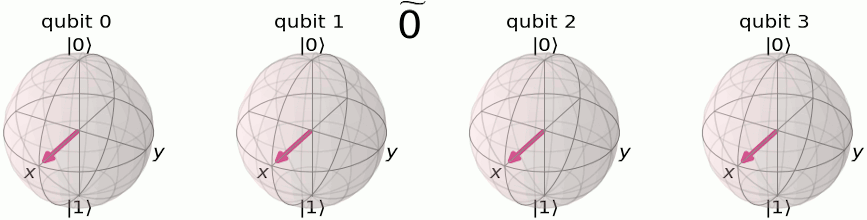

$$\textbf{Fig. }2:\text{ Counting in Fourier Basis}$$

In order to implement a quantum circuit of the QFT, we need two different gates. The first is the $H$-gate which we already know acts on a single qubit state $|x_k\rangle$ in the following way

$$H|x_k\rangle = \left(|0\rangle + e^{\frac{2\pi i}{2}x_k}|1\rangle \right)$$

The second gate we need is a controlled phase gate making use of two qubits: a control qubit and a target qubit. This gate is composed of the indentiy gate and a phase gate. We know a single qubit phase operation is represented by the matrix $P_k = \begin{pmatrix}1 & 0 \\ 0 & e^{\frac{2\pi i}{2^k}}\end{pmatrix}$ and a controlled operation as the block diagonal matrix $C = \begin{bmatrix}I & 0 \\ 0 & \text{Gate} \end{bmatrix}$ where $\text{Gate}$ is the operation applied to the target qubit. So the controlled version of our phase gate is written as

$$CP_k = \begin{bmatrix}I & 0 \\ 0 & P_k \end{bmatrix} = \begin{pmatrix}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & e^{\frac{2\pi i}{2^k}}\end{pmatrix}$$

Therefore, we can see that the $CP_k$ gate acts on the $|0\rangle$ an $|1\rangle$ states of a two-qubit state $|x_jx_l\rangle$ where the first qubit is the control and the second the target in the following ways:

$$CP_k|0x_l\rangle = |0x_l\rangle$$

$$CP_k|1x_l\rangle = e^{\frac{2\pi i}{2^k}x_k}|1x_l\rangle$$

Let's analyze how the QFT works on a quantum system with a single qubit state $|\psi\rangle = \alpha |0\rangle + \beta|1\rangle$. We can see here that $x_0 = \alpha$, $x_1 = \beta$, and $N = 2^n = 2^1 = 2$. To do this we will start by creating the QFT matrix for when $N=2$ and follow by applying it to our quantum state. 

$$\text{QFT}_2 = \frac{1}{\sqrt{2}}\begin{pmatrix}1 & 1 \\ 1 & \omega \end{pmatrix} = \frac{1}{\sqrt{2}}\begin{pmatrix}1 & 1 \\ 1 & e^{\frac{2\pi i}{N}} \end{pmatrix} = \frac{1}{\sqrt{2}}\begin{pmatrix}1 & 1 \\ 1 & \cos(\pi) + i \sin(\pi) \end{pmatrix} = \frac{1}{\sqrt{2}}\begin{pmatrix}1 & 1 \\ 1 & -1 \end{pmatrix}$$

$$\text{QFT}_2 |\psi\rangle = \frac{1}{\sqrt{2}}\begin{pmatrix}1 & 1 \\ 1 & -1 \end{pmatrix} \begin{pmatrix} \alpha \\ \beta \end{pmatrix} = \frac{1}{\sqrt{2}} \begin{pmatrix} \alpha + \beta \\ \alpha - \beta \end{pmatrix} = \frac{1}{\sqrt{2}}\left(\alpha + \beta\right)|0\rangle + \frac{1}{\sqrt{2}}\left(\alpha - \beta\right)|1\rangle$$

As we noted above, this is exactly equivalent to applying the $H$-gate to our state $|\psi\rangle$ showing that $\text{QFT}_2 = H$ transforming the amplitudes of the state from the computational basis to the Fourier basis. We can also write this new state with our Fourier basis notation:

$$\frac{1}{\sqrt{2}}\left(\alpha + \beta\right)|0\rangle + \frac{1}{\sqrt{2}}\left(\alpha - \beta\right)|1\rangle = \tilde{\alpha}|0\rangle + \tilde{\beta}|1\rangle$$

## Algorithm Construction

### Proof
$$ U_{FT}|j\rangle = \frac{1}{\sqrt{N}}\sum_{k \in N}e^{i2\pi \frac{kj}{N}}|k\rangle$$
$$ U_{FT}^\dagger|j\rangle = \frac{1}{\sqrt{N}}\sum_{k \in N}e^{-i2\pi \frac{kj}{N}}|k\rangle$$
Where k and j are binary numbers defined as $k = k_{n-1}2^{n-1} + \cdots + k_{0}2^{0}, j = j_{n-1}2^{n-1} +  \cdots j_02^{0}$ or equivently in base 2 $k = (k_{n-1} \cdots k_0.), j = (j_{n-1} \cdots j_0.)$

$$\frac{kj}{N} = k_0\frac{j}{2^n} +k_1\frac{j}{2^{n-1}} + \cdots + k_n\frac{j}{2} = k_0(j_n.j_{n-1} \cdots j_0) +k_1(j_nj_{n-1}.j_{n-2} \cdots j_0) + \cdots + k_n(j_n \cdots j_1.j_0)$$ 

Since $e^{i2\pi} = 1$, $e^{i2\pi n} = (e^{i2\pi})^{n} = 1^{n} = 1$. This means $e^{i2\pi n} = 1$. Therefore we can simplify the exponential in the following way.

$$e^{i2\pi\frac{kj}{N}} = e^{i2\pi k_0(j_n.j_{n-1} \cdots j_0)} e^{i2\pi k_1(j_nj_{n-1}.j_{n-2} \cdots j_0)} \cdots e^{i2\pi k_n(j_n \cdots j_1.j_0)} = e^{i2\pi k_0(0.j_{n-1} \cdots j_0)}e^{i2\pi k_1(0.j_{n-2} \cdots j_0)} \cdots e^{i2\pi k_n(0.j_0)}$$ 

Therefore we can write the original state like so

$$ U_{FT}|j\rangle = \frac{1}{\sqrt{N}}\sum_{k_{n-1},\cdots,k_0}e^{i2\pi k_0(0.j_{n-1} \cdots j_0)} e^{i2\pi k_1(0.j_{n-2} \cdots j_0)} \cdots e^{i2\pi k_n(0.j_0)}|k_{n-1}\cdots k_0\rangle$$

This means the state becomes

$$U_{FT}|j\rangle = \frac{1}{\sqrt{N}}\bigotimes_{n = 0}^{N-1}\left(|0\rangle +e^{\frac{2\pi i}{2^n} j}|1\rangle \right)$$

Before using the algorithm to convert to and from the Fourier basis, it is important to understand how to write an algorithm like this independently.

To start, lets try to find a pattern which we can use to contruct a circuit. Suppose we wanted to transform a single qubit into the Fourier basis. Using the tensor product definition for the final states of a $QFT$ gives us the equation:

$$QFT_2|j\rangle = \frac{1}{\sqrt{N}}\bigotimes_{n = 0}^{0}\left(|0\rangle +e^{\frac{2\pi i}{2^n} j}|1\rangle \right) = \frac{1}{\sqrt{2^1}}\left(|0\rangle +e^{\frac{2\pi i}{2^1} j}|1\rangle \right) = \frac{1}{\sqrt{2}}\left(|0\rangle +e^{j \pi i}|1\rangle \right) $$



$$QFT_2|0\rangle = \frac{1}{\sqrt{2}}\left(|0\rangle +e^{0}|1\rangle \right) = \frac{1}{\sqrt{2}}\left(|0\rangle + |1\rangle \right) = |+\rangle$$
$$QFT_2|1\rangle = \frac{1}{\sqrt{2}}\left(|0\rangle +e^{\pi i}|1\rangle \right) = \frac{1}{\sqrt{2}}\left(|0\rangle - |1\rangle \right) = |-\rangle$$

This means that $QFT_1$ is equivent to a Hadamard Gate.

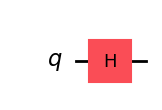

In [118]:
qft_example = QuantumCircuit(1)
qft_example.h(0)
qft_example.draw('mpl')

Suppose now we wanted to do a Fourier transform with two qubits instead of 1. Let $S$ be the decimal number that represents the state the $QFT$ is being applied to. This means that $S = q_0 2^0 + q_1 2^1 = q_0 + 2q_1$ for two qubits.

$$QFT_4|q_0q_1\rangle = \frac{1}{\sqrt{2^2}}\bigotimes_{n=0}^{1}\left(|0\rangle +e^{\frac{2\pi i}{2^n} S}|1\rangle \right)= \frac{1}{\sqrt{2}}\left(|0\rangle + e^{\frac{2\pi i}{2^1} S}|1\rangle \right) \otimes \frac{1}{\sqrt{2}}\left(|0\rangle +e^{\frac{2\pi i}{2^2} S}|1\rangle \right) = \frac{1}{\sqrt{2}}\left(|0\rangle + e^{\pi i S}|1\rangle \right) \otimes \frac{1}{\sqrt{2}}\left(|0\rangle +e^{\frac{\pi i}{2} S}|1\rangle \right)$$

Subtituting in $S = q_0 + 2q_1$

$$QFT_4|q_0q_1\rangle = \frac{1}{\sqrt{2}}\left(|0\rangle + e^{q_0\pi i}e^{q_1 2\pi i}|1\rangle \right) \otimes \frac{1}{\sqrt{2}}\left(|0\rangle +e^{q_0\frac{\pi i}{2}} e^{q_1 \pi i}|1\rangle \right) = \frac{1}{\sqrt{2}}\left(|0\rangle + e^{q_0\pi i}|1\rangle \right) \otimes \frac{1}{\sqrt{2}}\left(|0\rangle +e^{q_0\frac{\pi i}{2}} e^{q_1 \pi i}|1\rangle \right)$$

The state can be rewritten using $QFT_1$

$$QFT_4|q_0q_1\rangle = QFT_2|q_0\rangle \otimes \frac{1}{\sqrt{2}}\left(|0\rangle +e^{q_0\frac{\pi i}{2}} e^{q_1 \pi i}|1\rangle \right)$$

Suppose $q_0 = 0$

$$QFT_4|0q_1\rangle = QFT_2|0\rangle \otimes \frac{1}{\sqrt{2}}\left(|0\rangle + e^{q_1 \pi i}|1\rangle \right)$$

If $q_1=0$ then $q_1$ goes from $|0\rangle$ to $|+\rangle$ and if $q_1=1$ then $q_1$ goes from $|1\rangle$ to $|-\rangle$. This means we must apply a Hadamard gate to $q_1$.

Suppose now $q_1 = 0$

$$QFT_4|q_00\rangle = QFT_2|q_0\rangle \otimes \frac{1}{\sqrt{2}}\left(|0\rangle + e^{q_0\frac{\pi i}{2}}|1\rangle \right)$$

If $q_0=0$ then $q_1$ doen't rotate and if $q_0=1$ then $q_1$ goes rotates $\frac{\pi}{2}\text{ rad}$. This can be added to the circuit with a controlled phase gate.


<b> SWAPPING THE BITS? </b>

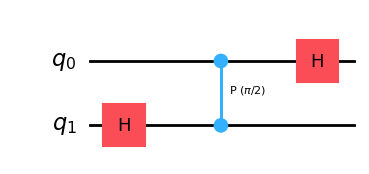

In [119]:
qft_example = QuantumCircuit(2)
# qft_example.x(0)
# qft_example.x(1)
qft_example.h(1)
qft_example.cp(pi/2, 0, 1)
qft_example.h(0)
qft_example.draw('mpl')

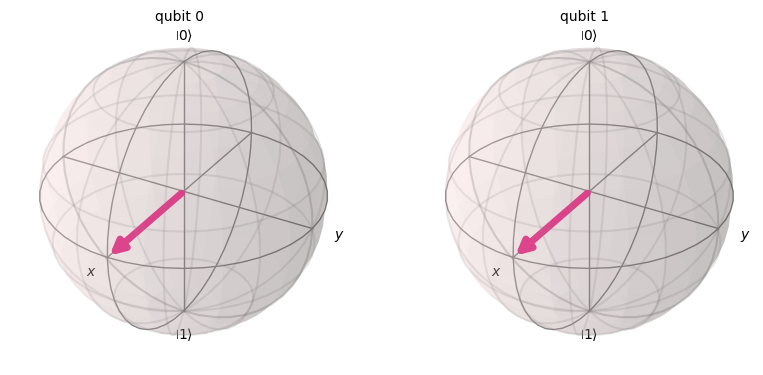

In [120]:
sv = Statevector(qft_example)
plot_bloch_multivector(qft_example)

# But look now these need to swap

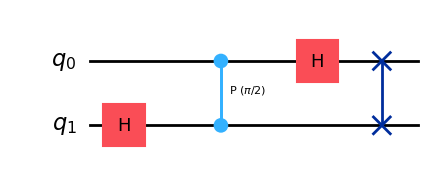

In [121]:
qft_example = QuantumCircuit(2)
# qft_example.x(0)
# qft_example.x(1)
qft_example.h(1)
qft_example.cp(pi/2, 0, 1)
qft_example.h(0)
qft_example.swap(0,1)
qft_example.draw('mpl')

Now that we know how to transform the first 2 qubits, what happens if we try to tranforms the third?
Let $S = q_0 2^0 + q_1 2^1 + q_2 2^2 = q_0 + 2q_1 + 4q_2$ since there are now 3 qubits.

$$QFT_3|q_0q_1q_2\rangle = \frac{1}{\sqrt{2^3}}\bigotimes_{n=0}^{2}\left(|0\rangle +e^{\frac{\pi i}{2^n} S}|1\rangle \right) =
\frac{1}{\sqrt{2}}\left(|0\rangle +e^{\pi i S}|1\rangle \right) \otimes 
\frac{1}{\sqrt{2}}\left(|0\rangle +e^{\frac{\pi i}{2} S}|1\rangle \right) \otimes 
\frac{1}{\sqrt{2}}\left(|0\rangle +e^{\frac{\pi i}{4} S}|1\rangle \right)
$$

This can be rewritten using $QFT_2$

$$QFT_3|q_0q_1q_2\rangle = QFT_2|q_0q_1\rangle \otimes \frac{1}{\sqrt{2}}\left(|0\rangle +e^{\frac{\pi i}{4} S}|1\rangle \right)$$

Substituting in $S = q_0 + 2q_1 + 4q_2$

$$QFT_3|q_0q_1q_2\rangle=  QFT_2|q_0q_1\rangle \otimes \frac{1}{\sqrt{2}}\left(|0\rangle + e^{\frac{\pi i}{4} q_0}e^{\frac{\pi i}{4} q_1(2)}e^{\frac{\pi i}{4} q_1(4)}|1\rangle \right) = QFT_2|q_0q_1\rangle \otimes \frac{1}{\sqrt{2}}\left(|0\rangle + e^{q_0 \frac{\pi i}{4} }e^{q_1\frac{\pi i}{2} }e^{q_1\pi i }|1\rangle \right)$$

So to transform $q_2$ into the fourier basis we will need to apply a rotation of $\frac{\pi}{4} \text{ rad}$ if $q_0$ is 1, $\frac{\pi}{2} \text{ rad}$ if and only if $q_1$ is 1, and $\pi \text{ rad}$ if and only if $q_2$ is 1. These transforms can easily be done with the controlled phase operations and one Hadamard gate.

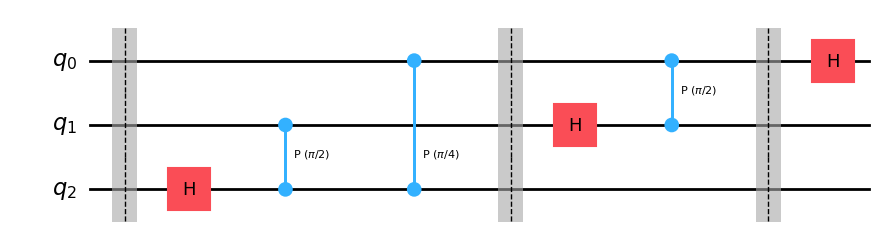

In [122]:
qft_example = QuantumCircuit(3)
# qft_example.x(0)
# qft_example.x(1)
# qft_example.x(2)
qft_example.barrier()
qft_example.h(2)
qft_example.cp(pi/2, 1, 2)
qft_example.cp(pi/4, 0, 2)
qft_example.barrier()
qft_example.h(1)
qft_example.cp(pi/2, 0, 1)
qft_example.barrier()
qft_example.h(0)
qft_example.draw('mpl')

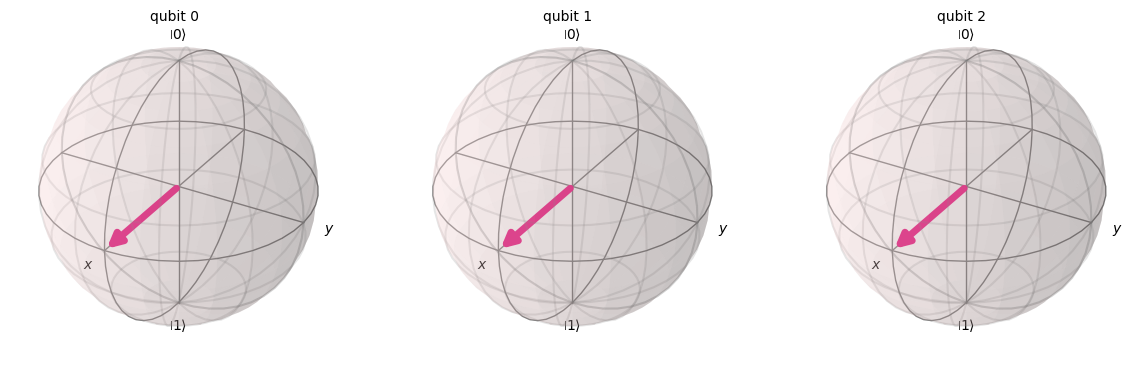

In [123]:
sv = Statevector(qft_example)
plot_bloch_multivector(qft_example)

# But look these should swap

so the final circuit becomes

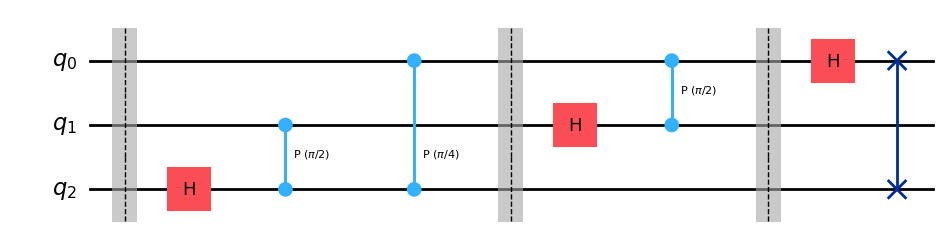

In [124]:
qft_example = QuantumCircuit(3)
# qft_example.x(0)
# qft_example.x(1)
# qft_example.x(2)
qft_example.barrier()
qft_example.h(2)
qft_example.cp(pi/2, 1, 2)
qft_example.cp(pi/4, 0, 2)
qft_example.barrier()
qft_example.h(1)
qft_example.cp(pi/2, 0, 1)
qft_example.barrier()
qft_example.h(0)
qft_example.swap(0,2)
qft_example.draw('mpl')

The pattern that follows from the examples is:

$QFT_{n}|q_0 \cdots q_{n-1}\rangle =  QFT_{n-1}|q_0 \cdots q_{n-2}\rangle \otimes \frac{1}{\sqrt{2}}\left(|0\rangle + e^{\frac{\pi i}{2^n} q_0}e^{\frac{\pi i}{2^{n-1}} q_1} \cdots e^{\pi i q_{n-1}}|1\rangle \right)$

Then swap them all.

This can easily be written using a for loop.


In [177]:
def add_fourier_transform(circuit, qubits, show_steps = False):
    circuit.barrier()
    for i in range(qubits):
        highest = qubits-i-1
        if show_steps: print("\nPreforming Fourier transform on qubit", highest)
        if show_steps: print("\tAdding H gate to qubit", highest)
        circuit.h(highest)
        for j in range(highest):
            qubit = highest-j-1
            if show_steps: print("\tControl Phase -π/2^"+str(highest-qubit)+" gate applied to", highest, "using qubit", qubit, "as control")
            circuit.cp(pi/2**(highest-qubit), qubit, highest)
        circuit.barrier()
    for i in range(int(qubits/2)):
        circuit.swap(i, qubits-i-1)
    if show_steps: print("\nCompleted transformation\n")

In [178]:
num = 11
bits = 6

In [179]:
binary_num = bin(num)[2:]
if len(binary_num)>bits: bits = len(binary_num)
print("Number (base10):", num)
print("Number (base2):", binary_num)
print("Number of bits:", bits)
expected_output = list(binary_num)
for i in range(int(len(binary_num)/2)):
    j = len(binary_num)-i-1
    temp = expected_output[i]
    expected_output[i] = expected_output[j]
    expected_output[j] = temp
print("Converted Input for Circuit:","".join(expected_output))

Number (base10): 11
Number (base2): 1011
Number of bits: 6
Converted Input for Circuit: 1101


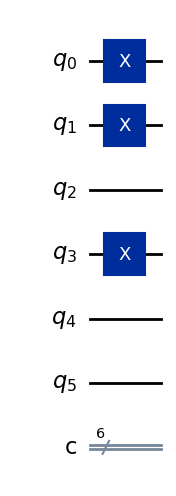

In [180]:
qc = QuantumCircuit(bits,bits)
for i in range(len(binary_num)):
    if int(expected_output[i]) == 1:
        qc.x(i)
qc.draw('mpl')

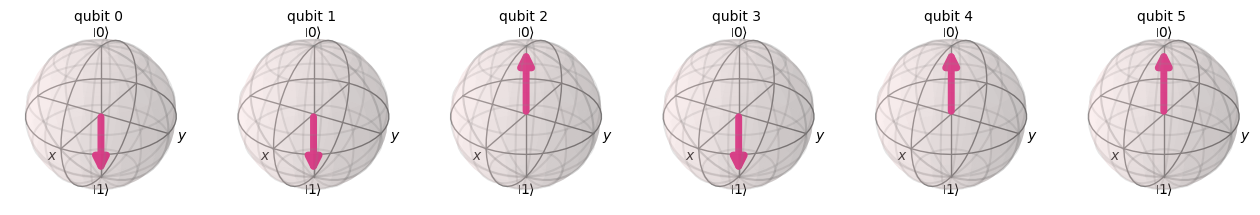

In [181]:
sv = Statevector(qc)
plot_bloch_multivector(sv)

After intitalizing the qubits, we then need to perform a Fourier transform. To do this you need 


Preforming Fourier transform on qubit 5
	Adding H gate to qubit 5
	Control Phase -π/2^1 gate applied to 5 using qubit 4 as control
	Control Phase -π/2^2 gate applied to 5 using qubit 3 as control
	Control Phase -π/2^3 gate applied to 5 using qubit 2 as control
	Control Phase -π/2^4 gate applied to 5 using qubit 1 as control
	Control Phase -π/2^5 gate applied to 5 using qubit 0 as control

Preforming Fourier transform on qubit 4
	Adding H gate to qubit 4
	Control Phase -π/2^1 gate applied to 4 using qubit 3 as control
	Control Phase -π/2^2 gate applied to 4 using qubit 2 as control
	Control Phase -π/2^3 gate applied to 4 using qubit 1 as control
	Control Phase -π/2^4 gate applied to 4 using qubit 0 as control

Preforming Fourier transform on qubit 3
	Adding H gate to qubit 3
	Control Phase -π/2^1 gate applied to 3 using qubit 2 as control
	Control Phase -π/2^2 gate applied to 3 using qubit 1 as control
	Control Phase -π/2^3 gate applied to 3 using qubit 0 as control

Preforming Fourier

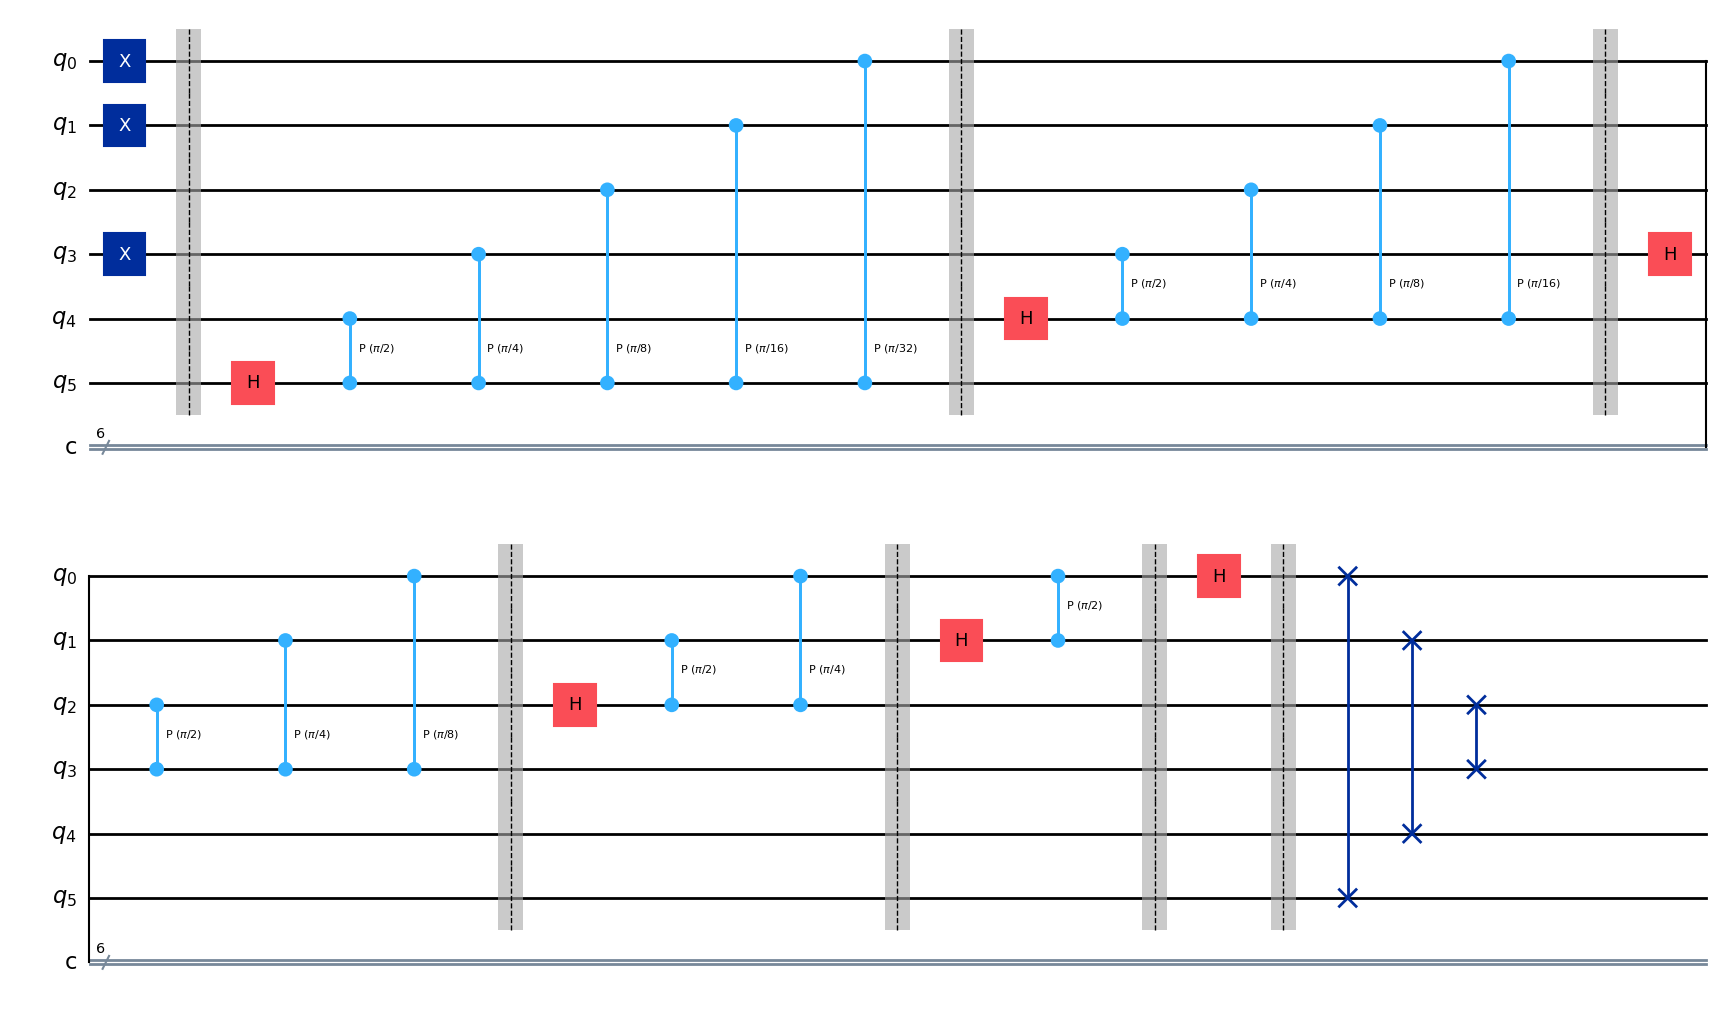

In [182]:
add_fourier_transform(qc, bits, show_steps = True)
qc.draw('mpl')

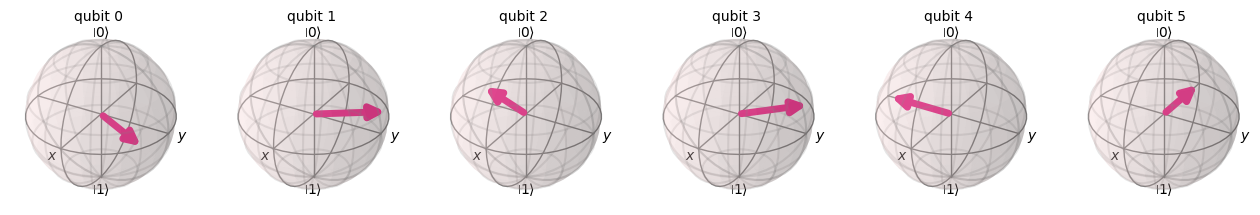

In [131]:
sv = Statevector(qc)
plot_bloch_multivector(sv)

To tranform something out of the fourier basis we just invert the regular fourier trasnform.

In [193]:
def add_inv_fourier_transform(circuit, qubits, show_steps = False):
    circuit.barrier()
    for i in range(int(qubits/2)):
        circuit.swap(i, qubits-i-1)
    for highest in range(qubits):
        if show_steps: print("\nPreforming inverse transform on qubit", highest)
        circuit.barrier()
        for qubit in range(highest):
            # qubit = highest-j-1
            if show_steps: print("\tControl Phase -π/2^"+str(qubit+1)+" gate applied to", highest, "using qubit", qubit, "as control")
            circuit.cp(-pi/2**(highest-qubit), highest, qubit)
        if show_steps: print("\tAdding H gate to qubit", highest)
        circuit.h(highest) 
    if show_steps: print("\nCompleted transformation\n")

In [194]:
num = 11
bits = 4

In [195]:
binary_num = bin(num)[2:]
bits = len(binary_num)
if len(binary_num)>bits: bits = len(binary_num)
print("Number (base10):", num)
print("Number (base2):", binary_num)
print("Number of bits:", bits)
expected_output = list(binary_num)
for i in range(int(len(binary_num)/2)):
    j = len(binary_num)-i-1
    temp = expected_output[i]
    expected_output[i] = expected_output[j]
    expected_output[j] = temp
print("Expected Output from Circuit:","".join(expected_output))

Number (base10): 11
Number (base2): 1011
Number of bits: 4
Expected Output from Circuit: 1101


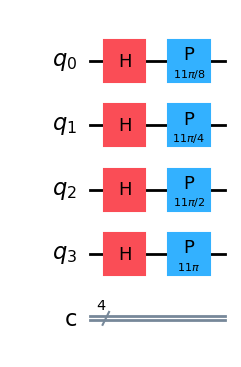

In [196]:
qc = QuantumCircuit(bits,bits)
for i in range(len(binary_num)):
    # this needs to be adjusted
    qc.h(i)
    qc.p(2*pi/2**(len(binary_num)-i) * num, i)
qc.draw('mpl')

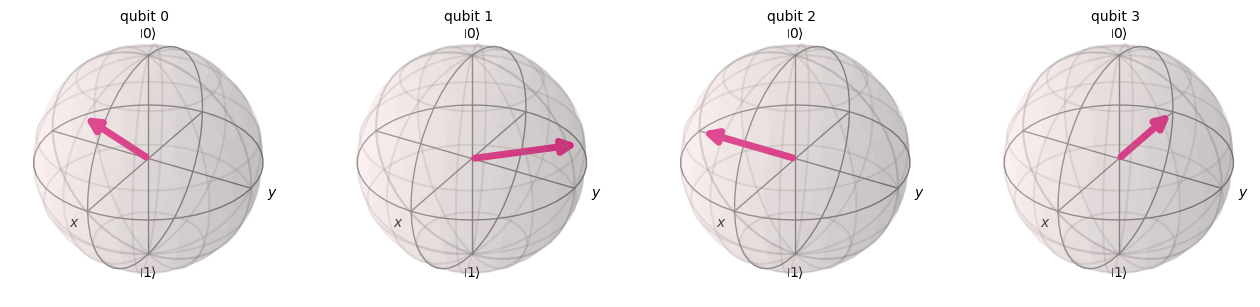

In [197]:
sv = Statevector(qc)
plot_bloch_multivector(sv)


Preforming inverse transform on qubit 0
	Adding H gate to qubit 0

Preforming inverse transform on qubit 1
	Control Phase -π/2^1 gate applied to 1 using qubit 0 as control
	Adding H gate to qubit 1

Preforming inverse transform on qubit 2
	Control Phase -π/2^1 gate applied to 2 using qubit 0 as control
	Control Phase -π/2^2 gate applied to 2 using qubit 1 as control
	Adding H gate to qubit 2

Preforming inverse transform on qubit 3
	Control Phase -π/2^1 gate applied to 3 using qubit 0 as control
	Control Phase -π/2^2 gate applied to 3 using qubit 1 as control
	Control Phase -π/2^3 gate applied to 3 using qubit 2 as control
	Adding H gate to qubit 3

Completed transformation



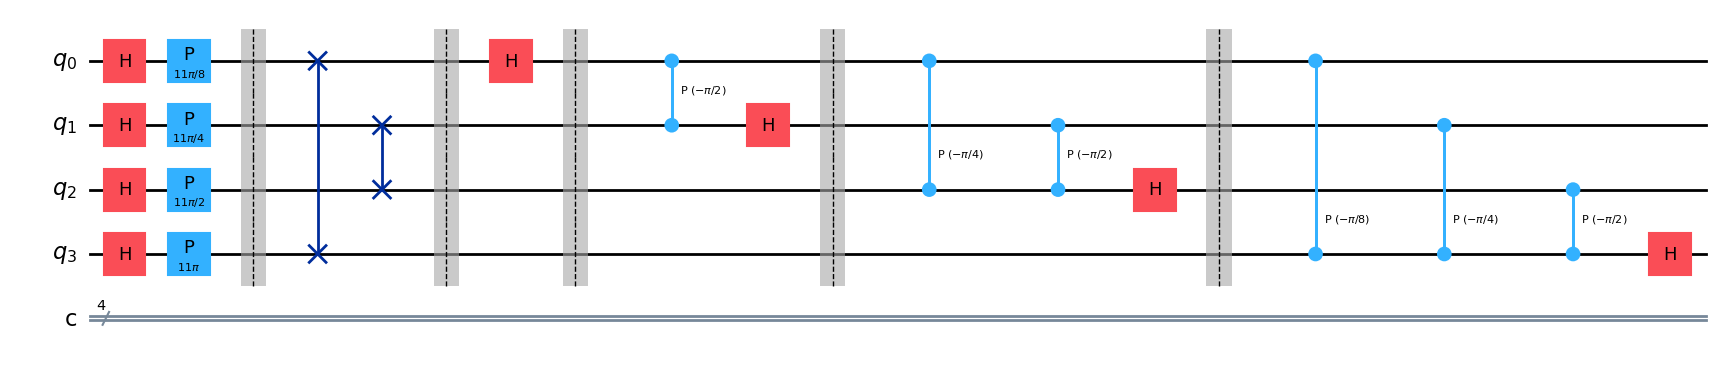

In [198]:
add_inv_fourier_transform(qc, bits, show_steps = True)
qc.draw('mpl')

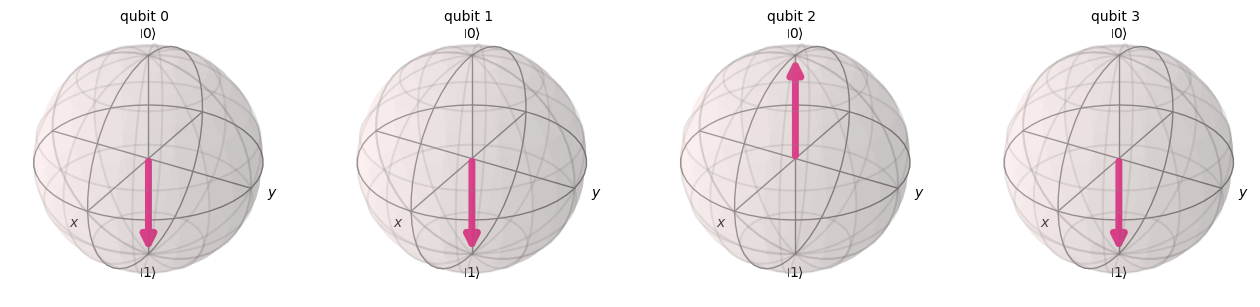

In [199]:
sv = Statevector(qc)
plot_bloch_multivector(sv)

Now that we have converted it to and from a fourier transform we should test to see if it works using a simulated backend.

In [203]:
def add_measurement(circuit, qubits):
    circuit.barrier()
    for qubit in range(qubits):
        circuit.measure(qubit,qubit)

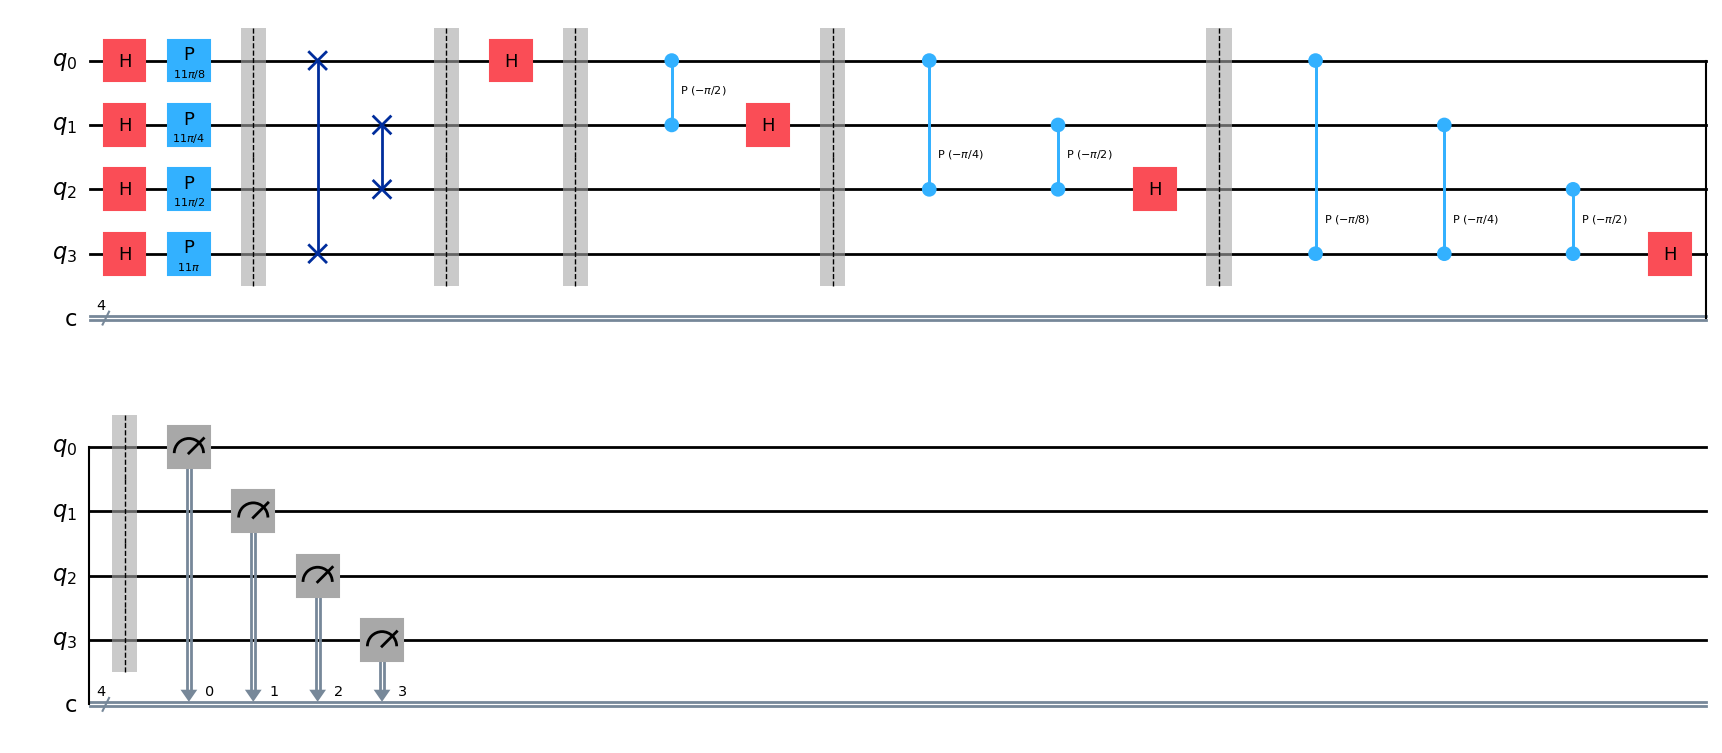

In [200]:
backend = BasicSimulator()

num_of_shots = 10000
add_measurement(qc, bits)
qc.draw('mpl')

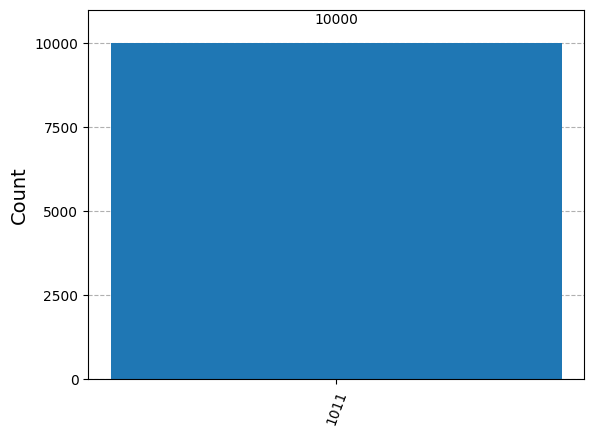

In [201]:
result = backend.run(qc, shots=num_of_shots).result()   
counts = result.get_counts()                    
plot_histogram(counts)